In [1]:
!pip install -e ../../

Obtaining file:///Users/fukai/projects/BaSiCpy
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for BaSiCPy (pyproject.toml) ... done
  Created wheel for BaSiCPy: filename=BaSiCPy-1.1.0-0.editable-py3-none-any.whl size=6231 sha256=09887b1c8a4adbbb1c73db577da737ec423d8f445dd0b9a0f54cfef20406766c
  Stored in directory: /private/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/pip-ephem-wheel-cache-n8n7271r/wheels/27/16/b1/2692f2d02db04ffefd7af1091113f0ef52a00fd39f93544489
Successfully built BaSiCPy
  Attempting uninstall: BaSiCPy
    Found existing installation: BaSiCPy 1.1.0
    Uninstalling BaSiCPy-1.1.0:
      Successfully uninstalled BaSiCPy-1.1.0


In [12]:
import numpy as np
import pandas as pd
from basicpy import BaSiC, datasets
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Arial"

findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic'

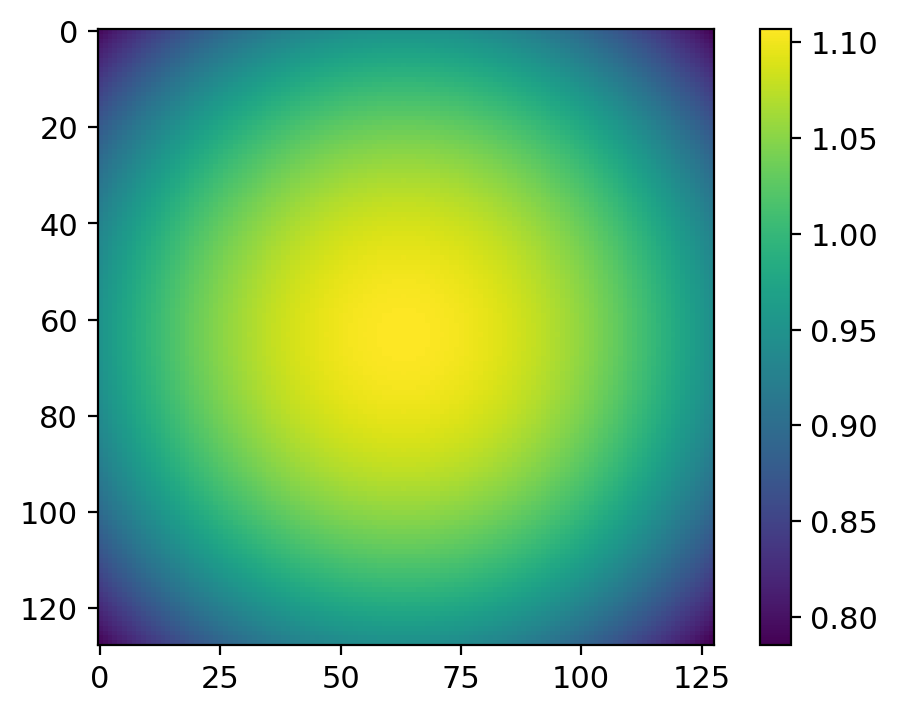

findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic'

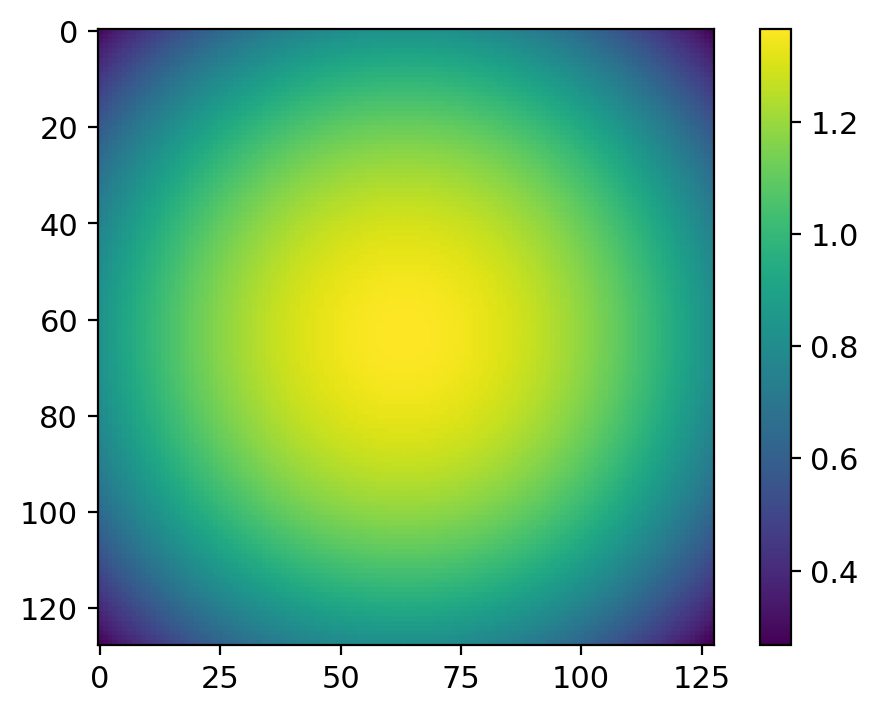

findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic'

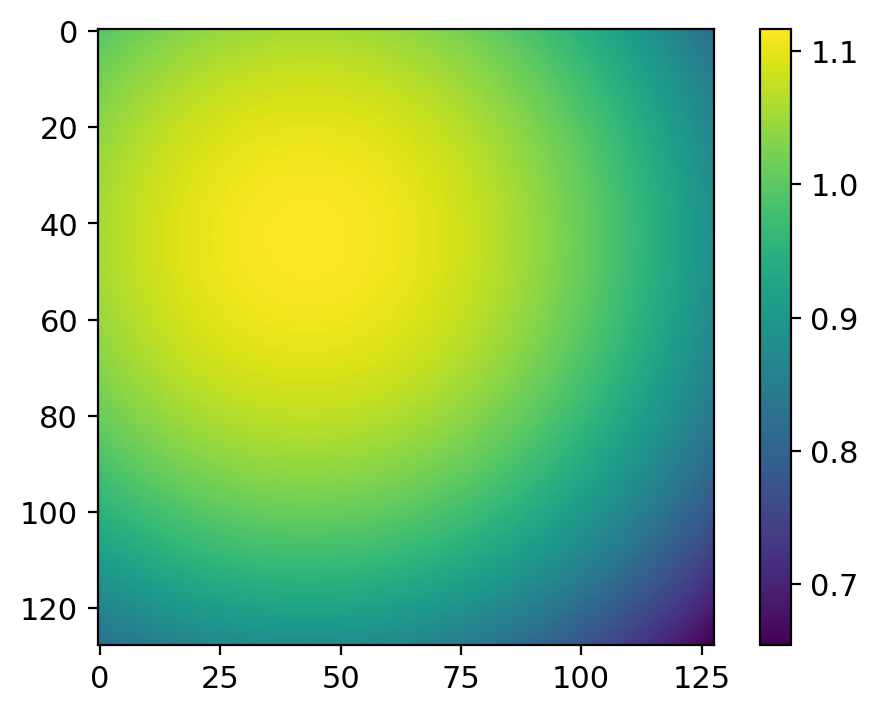

findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic'

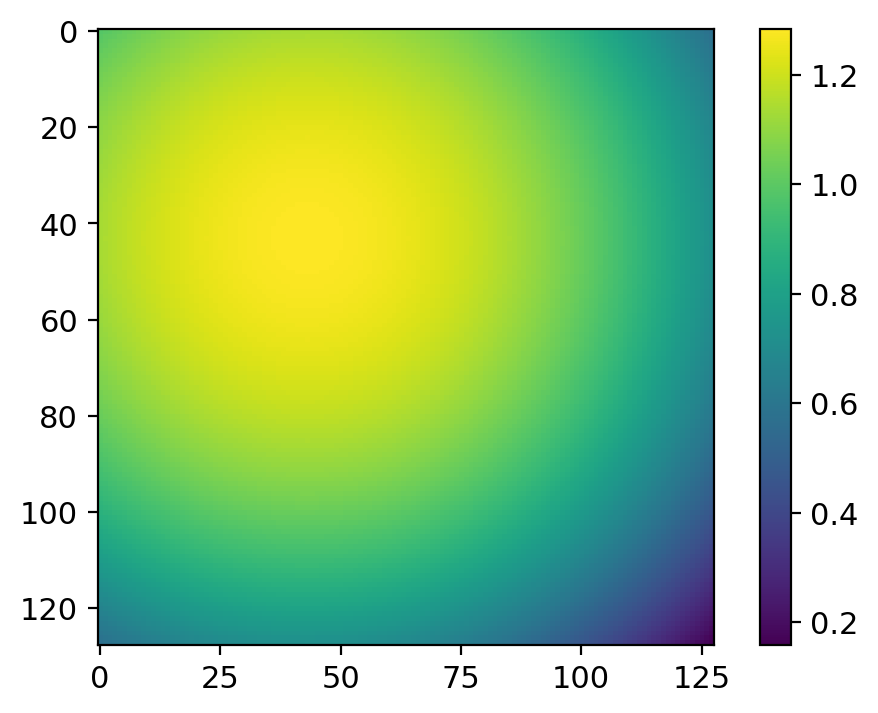

In [5]:
def generate_parabola(dim, coef, center):
    sizes = [128] * dim
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1 - c, size // 2 - c, size)
                for (c, size) in zip(center, sizes)
            ],
            indexing="ij"
        )
    )
    gradient = np.sum(grid**2, axis=0)
    gradient = coef * (np.max(gradient) - gradient) + 10
    return gradient / gradient.mean()


# Ground truth, for correctness checking

params = [
    (2, 0.0005, (0, 0)),
    (2, 0.005, (0, 0)),
    (2, 0.0005, (-20, -20)),
    (2, 0.005, (-20, -20)),
]

flatfield_profiles = [generate_parabola(*ps) for ps in params]

for p in flatfield_profiles:
    plt.imshow(p)
    plt.colorbar()
    plt.show()

# See how random out-of-flatfield objects affect the estimation

aim ... add random (uncorrelated) object that show intensity profile different from the fitted flatfield, see how it affects the fitting quality

## Flatfield only cases

In [6]:
blob_size = 2
blob_dist = lambda: np.random.normal(0, 2)

### single image test 

In [7]:
def generate_cluttered_images(
    true_flatfield, intensity, n_images, ave_count, blob_dist
):
    poss = np.array(
        [
            [
                np.random.uniform(
                    -size // 2 + 1,
                    size // 2,
                )
                for size in true_flatfield.shape
            ]
            for _ in range(np.random.poisson(ave_count))
        ]
    )

    images = []
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1, size // 2, size)
                for size in true_flatfield.shape
            ],
            indexing="ij"
        )
    )
    for _ in range(n_images):
        image = true_flatfield.copy()
        for p in poss:
            image += (
                np.exp(
                    -np.sum((grid - p[:, np.newaxis, np.newaxis]) ** 2, axis=0)
                    / 2.0
                    / blob_size**2
                )
                / np.sqrt(2 * np.pi * blob_size**2) ** 2
                * blob_dist()
            )
        image = image * intensity
        image = np.clip(image, 0, None)
        image = np.random.poisson(image)
        images.append(image)
    return np.array(images)

findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic'

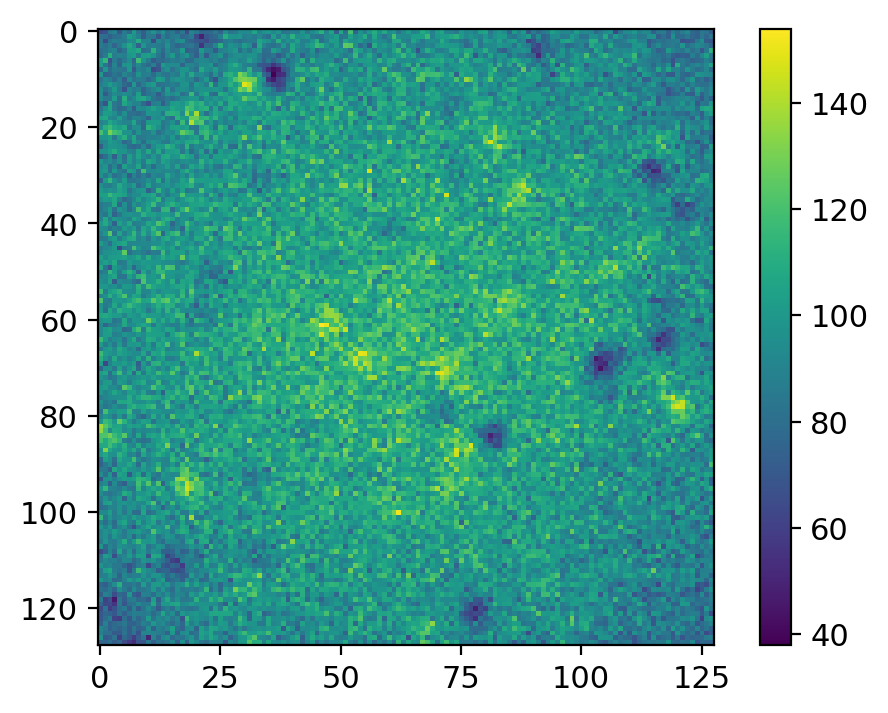

In [8]:
images = generate_cluttered_images(
    flatfield_profiles[0], 100, 100, 100, lambda: np.random.normal(0, 5)
)
plt.imshow(images[0])
plt.colorbar()

findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic'

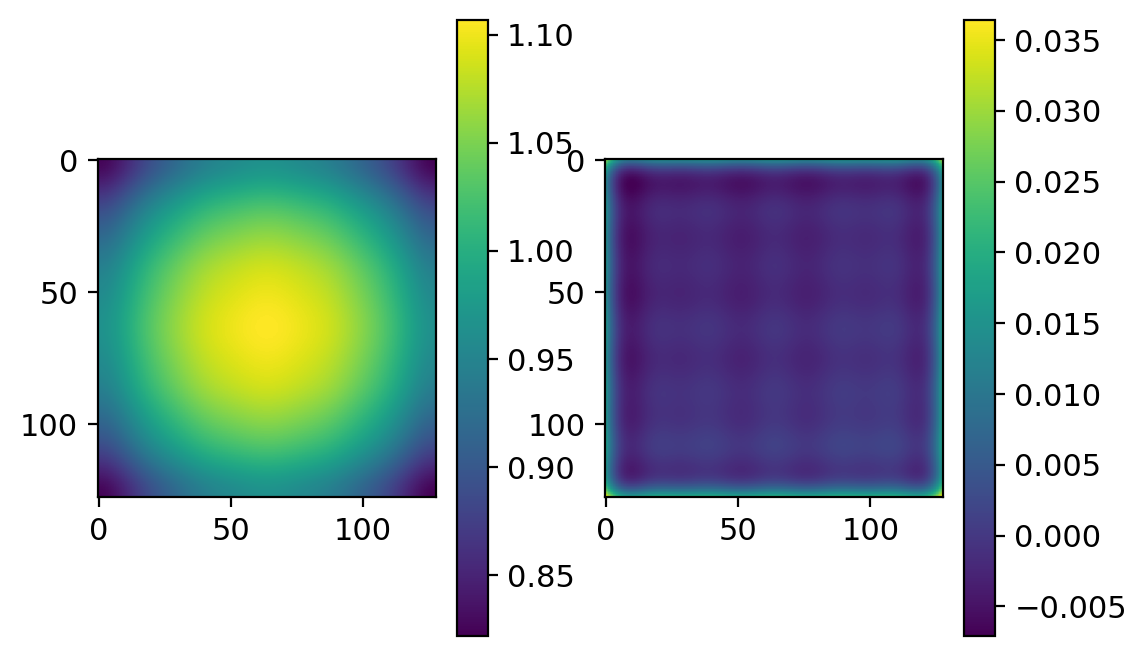

In [9]:
b = BaSiC(get_darkfield=False)
b.fit(np.array(images))
plt.subplot(121)
plt.imshow(b.flatfield)
plt.colorbar()
plt.subplot(122)
plt.imshow(b.flatfield / np.mean(b.flatfield) - flatfield_profiles[0])
plt.colorbar()

findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'IPAPGothic'

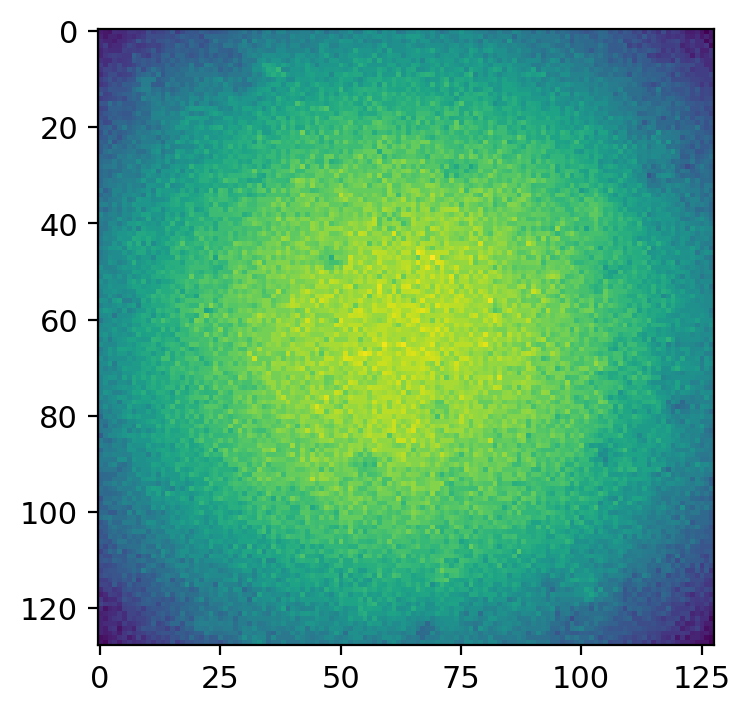

In [10]:
plt.imshow(np.median(images, axis=0))

### fit multiple images 

In [ ]:
            search_space = {
                "smoothness_flatfield": 
            }
            if self.get_darkfield:
                search_space.update(
                    {
                        "smoothness_darkfield": [0] + list(np.logspace(-3, 1, 15)),
                        "sparse_cost_darkfield": [0] + list(np.logspace(-3, 1, 15)),
                    }
                )

In [14]:
np.random.seed(202306)
repeat = 100
blob_dists = {
    "unbiased": lambda: np.random.normal(0, 5),
    "biased": lambda: np.random.normal(10, 5),
}
conditions = list(
    product(
        range(
            len(flatfield_profiles)
        ),  # true_flatfield_id (index of flatfield_profiles)
        [10, 100, 1000],  # intensity
        [10, 100, 1000],  # ave_count
        [10, 20, 50, 100, 200, 500, 1000],  # n_images
        ["biased", "unbiased"],  # blob_dist_key
        ["ladmap", "approximate"],  # fitting_mode
        list(np.logspace(-3, 1, 15)),  # smoothness_flatfield
    )
)

parameters = []
flatfields = []
for (
    true_flatfield_id,
    intensity,
    ave_count,
    n_images,
    blob_dist_key,
    fitting_mode,
    smoothness_flatfield,
) in tqdm(conditions):
    parameters.append(
        {
            "truth_flatfield_id": true_flatfield_id,
            "intensity": intensity,
            "ave_count": ave_count,
            "n_images": n_images,
            "blob_dist_key": blob_dist_key,
            "fitting_mode": fitting_mode,
            "smoothness_flatfield": smoothness_flatfield,
        }
    )
    images = generate_cluttered_images(
        flatfield_profiles[true_flatfield_id],
        intensity=intensity,
        n_images=n_images,
        ave_count=ave_count,
        blob_dist=blob_dists[blob_dist_key],
    )
    b = BaSiC(
        get_darkfield=False,
        fitting_mode=fitting_mode,
        smoothness_flatfield=smoothness_flatfield,
    )
    b.fit(images)
    flatfields.append(b.flatfield)
plt.imshow(images[0])
plt.colorbar()
plt.show()
plt.imshow(b.flatfield)
plt.colorbar()

  1%|          | 93/15120 [01:11<3:52:21,  1.08it/s]2023-06-25 11:24:13.333369: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 5m18.522391s

********************************
[Compiling module jit__fit_jit] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
  1%|▏         | 226/15120 [36:42<40:18:39,  9.74s/it]


KeyboardInterrupt: 

## Including darkfield